In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from shapely.affinity import scale
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import numpy as np

In [2]:
geojson = gpd.read_file('area_0.geojson')

In [3]:
centroid = geojson.geometry.centroid[0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_5404\279251374.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = geojson.geometry.centroid[0]


In [4]:
def equalize_and_scale_polygon(polygon, factor):
    # Get the bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds
    
    # Calculate the current width and height of the bounding box
    current_width = maxx - minx
    current_height = maxy - miny
    
    # Determine the larger dimension and use it as the target size
    target_size = max(current_width, current_height)
    
    # Calculate the scaling factors to equalize the width and height
    xfact = target_size / current_width
    yfact = target_size / current_height
    
    # Adjust the scaling factor to increase the polygon size
    xfact *= factor
    yfact *= factor
    
    # Get the centroid of the polygon
    centroid = polygon.centroid
    
    # Scale the polygon relative to its centroid
    scaled_polygon = scale(polygon, xfact=xfact, yfact=yfact, origin=centroid)
    
    return scaled_polygon

In [5]:
geojson['geometry'] = geojson['geometry'].apply(
    lambda geom: equalize_and_scale_polygon(geom, 5) if isinstance(geom, Polygon) else geom
)

In [6]:
def crop_band(band_path, geojson):
    with rasterio.open(band_path) as src:
        # Reproject GeoJSON to match the CRS of the band
        geojson = geojson.to_crs(src.crs)
        # Extract geometry
        geometry = [geojson.geometry[0]]
        # Crop the image using the geometry
        out_image, out_transform = mask(src, geometry, crop=True)
        
        # Copy the metadata of the original file
        out_meta = src.meta.copy()
        
        # Update the metadata with new dimensions, transform, etc.
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        return out_image, out_meta

In [7]:
band2_cropped, out_meta = crop_band('imagery/0/T19LCF_20221125T145731_B02.jp2', geojson)
band3_cropped = crop_band('imagery/0/T19LCF_20221125T145731_B03.jp2', geojson)[0]
band4_cropped = crop_band('imagery/0/T19LCF_20221125T145731_B04.jp2', geojson)[0]

In [8]:
band2_cropped = np.squeeze(band2_cropped)  # Now (height, width)
band3_cropped = np.squeeze(band3_cropped)  # Now (height, width)
band4_cropped = np.squeeze(band4_cropped)  # Now (height, width)

In [9]:
image_rgb = np.stack((band4_cropped, band3_cropped, band2_cropped), axis=0)

In [10]:
image_rgb_normalized = np.clip(image_rgb, 0, 3466)  # Clip values to [0, 3466]
image_rgb_normalized = (image_rgb_normalized / 3466) * 255  # Normalize to [0, 255]
image_rgb_normalized = image_rgb_normalized.astype(np.uint8)

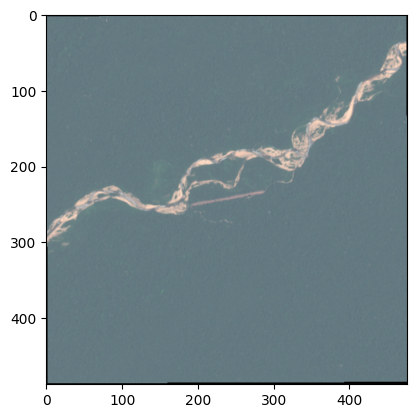

<Axes: >

In [11]:
show(image_rgb_normalized)

In [12]:
out_meta.update({
    "count": image_rgb.shape[0],  # Number of bands (R, G, B)
    "dtype": image_rgb.dtype      # Data type of the image
})

In [13]:
with rasterio.open('cropped_rgb_image.tif', 'w', **out_meta) as dest:
    dest.write(image_rgb)